In [41]:
import numpy as np
import bisect

from matplotlib import pyplot as plt
import matplotlib

In [2]:
from pixel2d import Pixel2D

In [3]:
from topologicalunionfind import TopologicalUnionFind

### Reading Slice

In [4]:
binary = np.fromfile('../cube/map.bin')
binary.shape

(87464,)

In [5]:
cube_shape = (26, 29, 116)

In [6]:
cube = binary.reshape(cube_shape)
cube.shape

(26, 29, 116)

In [7]:
aslice = cube[:,:,60]
aslice.shape

(26, 29)

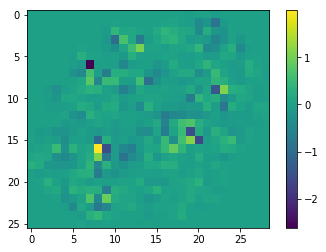

In [8]:
plt.imshow(aslice)
plt.colorbar()
plt.show()

In [9]:
bslice = (aslice == 0) * 1
bslice.shape

(26, 29)

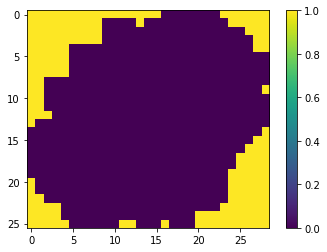

In [10]:
plt.imshow(bslice)
plt.colorbar()
plt.show()

### Getting Data

In [12]:
reverse = True
diagonal = False

In [13]:
if reverse:
    dataUF = aslice.max() - aslice + 1
    dataPH = aslice.max() - aslice + 1
else:
    dataUF = aslice
    dataPH = aslice - aslice.min() + 1

### Generating Input File

In [14]:
if dataPH.dtype == np.float_:
    multiplier = 1e6
else:
    multiplier = 1

In [15]:
dataPH = (dataPH * multiplier).astype(int)

In [16]:
if reverse: 
    if diagonal:
        ainput = 'slice2dr.txt'
    else:
        ainput = 'slice2dr2.txt'
else:
    if diagonal:
        ainput = 'slice2d.txt'
    else:
        ainput = 'slice2d2.txt'

In [17]:
def write2dPath(f, data, i, j, ni, nj):
    if ni < 0 or nj < 0:
        return
    try:
        f.write('1 {} {} {} {} {}\n'.format(i, j, ni, nj, max(data[i, j], data[ni, nj])))
    except:
        pass

In [18]:
with open(ainput, 'w') as f:
    f.write(str(len(dataPH.shape))+'\n')
    for i in range(0, dataPH.shape[0]):
        for j in range(0, dataPH.shape[1]):
            f.write('0 {} {} {}\n'.format(i, j, dataPH[i, j]))
            write2dPath(f, dataPH, i, j, i+1, j)
            write2dPath(f, dataPH, i, j, i, j+1)
            if diagonal:
                write2dPath(f, dataPH, i, j, i+1, j+1)
                write2dPath(f, dataPH, i, j, i+1, j-1)

### Running

In [19]:
import subprocess

In [20]:
subprocess.run(['./perseusMac', 'nmfsimtop', ainput, ainput[:-4]])

CompletedProcess(args=['./perseusMac', 'nmfsimtop', 'slice2dr2.txt', 'slice2dr2'], returncode=0)

### Reading Output File for Cubical

In [21]:
if reverse: 
    if diagonal:
        aoutput = 'slice2dr_0.txt'
    else:
        aoutput = 'slice2dr2_0.txt'
else:
    if diagonal:
        aoutput = 'slice2d_0.txt'
    else:
        aoutput = 'slice2d2_0.txt'

In [22]:
pd2 = []
with open(aoutput) as f:
    for l in f.readlines():
        info = l.split()
        start = int(info[0]) / multiplier
        end = int(info[1]) / multiplier if int(info[1]) != -1 else -1
        pd2.append((start, end))
pd2 = sorted(pd2, key=lambda x:x[0])

In [58]:
persistencePH = []
for birth, death in pd2:
    if reverse:
        nbirth = aslice.max() - death + 1 if death != -1 else aslice.min() 
        ndeath = aslice.max() - birth + 1
    else:
        nbirth = birth + aslice.min() - 1
        ndeath = death + aslice.min() - 1 if death != -1 else aslice.max()
    persistencePH.append((nbirth, ndeath))

### Creating Pixel Objects

In [60]:
mat = []
for i in range(dataUF.shape[0]):
    row = []
    for j in range(dataUF.shape[1]):
        element = dataUF[i][j]
        row.append(Pixel2D(i, j, element))
    mat.append(row)

In [61]:
arr = sorted([e for row in mat for e in row])

### Getting Neighbors for a Pixel

In [62]:
def append2DNeighbor(neighbors, x, y):
    if x < 0 or y < 0:
        return
    try:
        neighbors.append(mat[x][y])
    except:
        pass

In [63]:
def get_neighbors(pixel, diagonal=False):
    neighbors = []
    x = pixel.getX()
    y = pixel.getY()
    append2DNeighbor(neighbors, x-1, y)
    append2DNeighbor(neighbors, x+1, y)
    append2DNeighbor(neighbors, x, y-1)
    append2DNeighbor(neighbors, x, y+1)
    if diagonal:
        append2DNeighbor(neighbors, x-1, y-1)
        append2DNeighbor(neighbors, x-1, y+1)
        append2DNeighbor(neighbors, x+1, y-1)
        append2DNeighbor(neighbors, x+1, y+1)
    return neighbors

In [64]:
set([len(get_neighbors(pixel)) for pixel in arr])

{2, 3, 4}

In [65]:
set([len(get_neighbors(pixel, True)) for pixel in arr])

{3, 5, 8}

### Creating Topological Union-find

In [66]:
tuf = TopologicalUnionFind()
tuf

<UnionFind:
	elts=[],
	siz=[],
	par=[],
n_elts=0,n_comps=0>

In [67]:
for pixel in arr:
    tuf.add(pixel, pixel.getV())
    for neighbor in get_neighbors(pixel, diagonal):
        tuf.union(pixel, neighbor, pixel.getV())

In [68]:
pd = tuf.persistence()

In [69]:
persistenceUF = []
for birth, death in pd:
    if reverse:
        nbirth = aslice.max() - death + 1 if np.isfinite(death) else aslice.min() 
        ndeath = aslice.max() - birth + 1
    else:
        nbirth = birth
        ndeath = death if np.isfinite(death) else aslice.max()
    persistenceUF.append((nbirth, ndeath))

### Visualization

In [70]:
y = np.arange(0, len(persistenceUF))

In [71]:
xmin = [birth for birth, death in persistenceUF]
xmax = [death for birth, death in persistenceUF]

In [72]:
if reverse:
    xlim = (max(xmax), min(xmin))
else:
    xlim = (min(xmin), max(xmax))

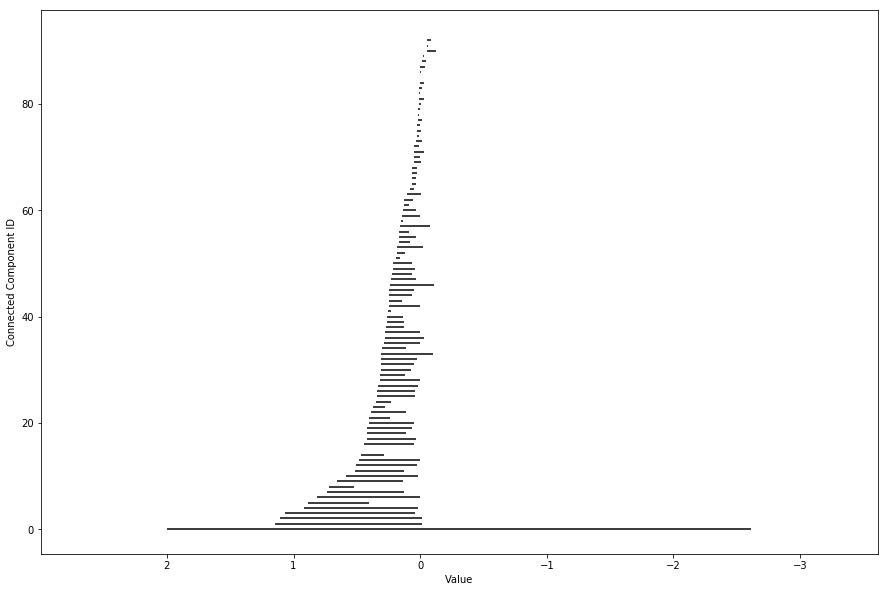

In [94]:
height = 2 + len(persistenceUF) // 10
height = 10 if height > 10 else height
plt.figure(figsize=(15,height))
plt.hlines(y=y, xmin=xmin, xmax=xmax)
plt.xlim(xlim[0], xlim[1])
plt.gca().xaxis.set_major_locator(matplotlib.ticker.MultipleLocator())
# plt.gca().yaxis.set_major_locator(matplotlib.ticker.MultipleLocator())
plt.xlabel('Value')
plt.ylabel('Connected Component ID')
plt.show()

In [74]:
xmin = [birth for birth, death in persistenceUF]
xmax = [death for birth, death in persistenceUF]

In [75]:
if reverse:
    xlim = (max(xmax)+1, min(xmin)-1)
    xmin, xmax = xmax, xmin
else:
    xlim = (min(xmin)-1, max(xmax)+1)

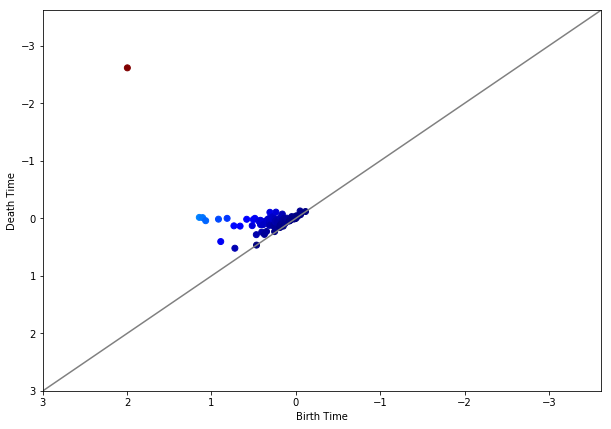

In [76]:
plt.figure(figsize=(10,7))
plt.scatter(xmin, xmax, c=np.array(xmax)-np.array(xmin), cmap='jet_r')
plt.xlim(xlim[0], xlim[1])
plt.ylim(xlim[0], xlim[1])
plt.gca().xaxis.set_major_locator(matplotlib.ticker.MultipleLocator())
plt.gca().yaxis.set_major_locator(matplotlib.ticker.MultipleLocator())
plt.xlabel('Birth Time')
plt.ylabel('Death Time')
plt.plot([xlim[0], xlim[1]], [xlim[0], xlim[1]], c='grey')
plt.show()

### Visualization2

In [77]:
y = np.arange(0, len(persistencePH))

In [78]:
xmin = [birth for birth, death in persistencePH]
xmax = [death for birth, death in persistencePH]

In [79]:
if reverse:
    xlim = (max(xmax), min(xmin))
else:
    xlim = (min(xmin), max(xmax))

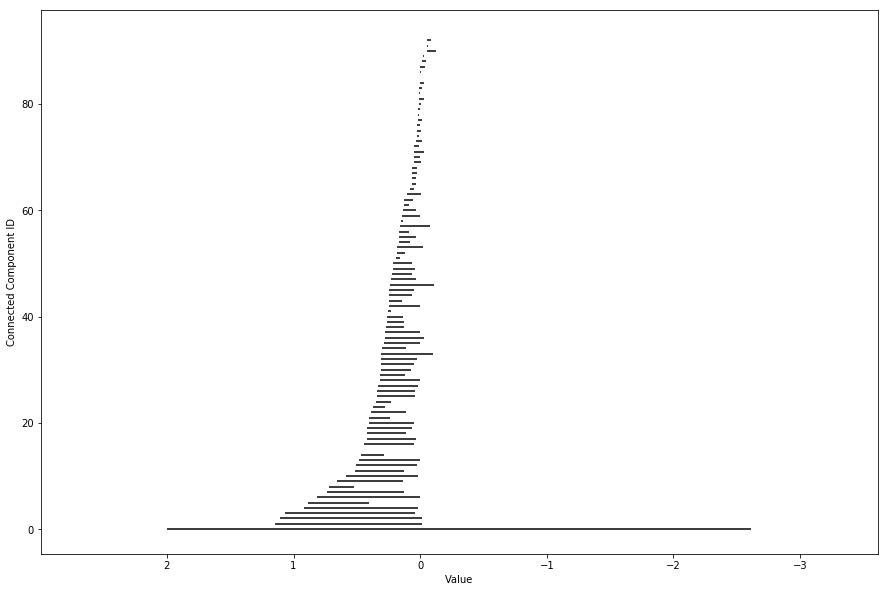

In [91]:
height = 2 + len(persistencePH) // 10
height = 10 if height > 10 else height
plt.figure(figsize=(15,height))
plt.hlines(y=y, xmin=xmin, xmax=xmax)
plt.xlim(xlim[0], xlim[1])
plt.gca().xaxis.set_major_locator(matplotlib.ticker.MultipleLocator())
# plt.gca().yaxis.set_major_locator(matplotlib.ticker.MultipleLocator())
plt.xlabel('Value')
plt.ylabel('Connected Component ID')
plt.show()

In [83]:
xmin = [birth for birth, death in persistencePH]
xmax = [death for birth, death in persistencePH]

In [84]:
if reverse:
    xlim = (max(xmax)+1, min(xmin)-1)
    xmin, xmax = xmax, xmin
else:
    xlim = (min(xmin)-1, max(xmax)+1)

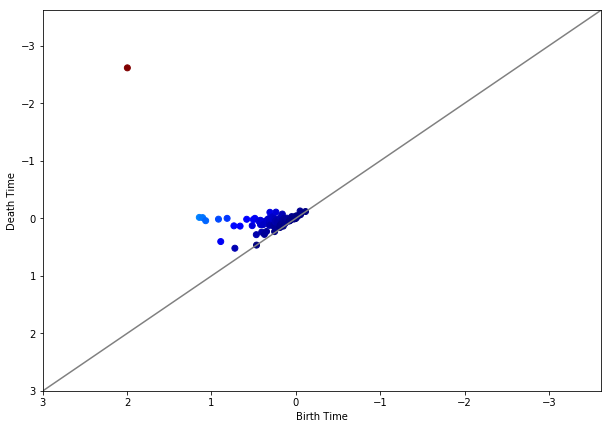

In [93]:
plt.figure(figsize=(10,7))
plt.scatter(xmin, xmax, c=np.array(xmax)-np.array(xmin), cmap='jet_r')
plt.xlim(xlim[0], xlim[1])
plt.ylim(xlim[0], xlim[1])
plt.gca().xaxis.set_major_locator(matplotlib.ticker.MultipleLocator())
plt.gca().yaxis.set_major_locator(matplotlib.ticker.MultipleLocator())
plt.xlabel('Birth Time')
plt.ylabel('Death Time')
plt.plot([xlim[0], xlim[1]], [xlim[0], xlim[1]], c='grey')
plt.show()